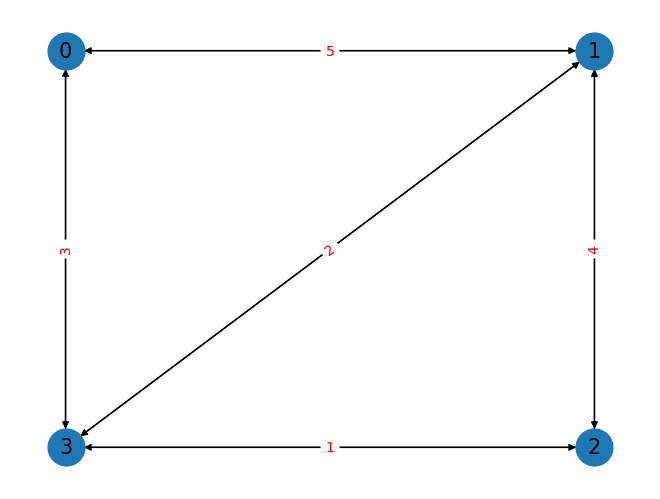

In [59]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Create a new graph
G = nx.Graph()

# Add nodes
G.add_node(0, pos=(0, 1))
G.add_node(1, pos=(1, 1))
G.add_node(2, pos=(1, 0))
G.add_node(3, pos=(0, 0))

# Add edges with weights
G.add_edge(0, 1, weight=5)
G.add_edge(0, 3, weight=3)
G.add_edge(1, 2, weight=4)
G.add_edge(2, 3, weight=1)
G.add_edge(1, 3, weight=2)

G = nx.DiGraph(G)

# Specify the weights as labels
edge_labels = {(i, j): w['weight'] for i, j, w in G.edges(data=True)}

# Get the positions
pos = nx.get_node_attributes(G, 'pos')

# Draw the graph
nx.draw(G, pos, with_labels=True, node_size=700, edge_color='k', linewidths=1, font_size=15)

# Draw edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

# Show plot
plt.show()


In [44]:
from dimod import BQM
def sp_objective(bqm: BQM, G: nx.DiGraph):
    # c_0 * x_0 + c_1 * x_1 + ... + c_n * x_n
    for u, v in G.edges():
        bqm.add_linear(f"x_{u}_{v}", G[u][v]['weight']) # 2*x_0_1 + ...
    return bqm

def sp_constraint(bqm: BQM, G: nx.DiGraph, s: int, e: int):
    
    c = []
    for u, v in G.out_edges(s):
        c.append((f"x_{u}_{v}", 1))
    print(c)
    bqm.add_linear_equality_constraint(c, constant=-1, lagrange_multiplier=50)
    
    c = []
    for u, v in G.in_edges(s):
        c.append((f"x_{u}_{v}", 1))
    print(c)
    bqm.add_linear_equality_constraint(c, constant=0, lagrange_multiplier=50)
    
    c = []
    for u, v in G.in_edges(e):
        c.append((f"x_{u}_{v}", 1))
    bqm.add_linear_equality_constraint(c, constant=-1, lagrange_multiplier=50)
    
    c = []
    for u, v in G.out_edges(e):
        c.append((f"x_{u}_{v}", 1))
    
    bqm.add_linear_equality_constraint(c, constant=0, lagrange_multiplier=50)
    for node in G.nodes():
        c = []
        if node == s or node == e:
            continue

        for u, v in G.out_edges(node):
            c.append((f"x_{u}_{v}", 1))
        for u, v in G.in_edges(node):
            c.append((f"x_{u}_{v}", -1))
        
        L = sum([G[u][v]['weight'] for u, v in G.edges()])
        bqm.add_linear_equality_constraint(c, constant=0, lagrange_multiplier=50)
        
    return bqm

In [45]:
from neal import SimulatedAnnealingSampler

def anneal(bqm, num_reads):
    sampler = SimulatedAnnealingSampler()
    sampleset = sampler.sample(bqm, num_reads=num_reads)
    return sampleset

In [46]:
def sp_solution(num_reads, G: nx.DiGraph, start: int, end: int):
    
    bqm = BQM("BINARY")
    bqm = sp_objective(bqm, G)
    bqm = sp_constraint(bqm, G, start, end)

    sampleset = anneal(bqm, num_reads)

    solution = (None, None)
    for sol in sampleset.data(fields=["sample", "energy"]):
        solution = sol
        break
    # Do not modify anything below this line
    return solution, bqm

In [47]:
ans, bqm = sp_solution(1000, G, 3, 1)
print(ans)

[('x_3_0', 1), ('x_3_4', 1), ('x_3_1', 1)]
[('x_0_3', 1), ('x_1_3', 1), ('x_4_3', 1)]


Sample(sample={'x_0_1': 0, 'x_0_3': 0, 'x_1_0': 0, 'x_1_3': 0, 'x_1_4': 0, 'x_3_0': 0, 'x_3_1': 1, 'x_3_4': 0, 'x_4_1': 0, 'x_4_3': 0}, energy=2.0)


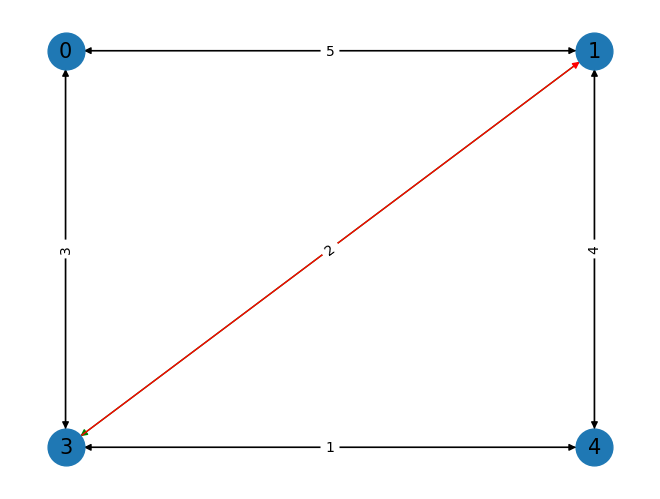

In [48]:
ans[0]
edge_colors = []
for u, v in G.edges():
    if ans[0][f'x_{u}_{v}'] == 1 and ans[0][f'x_{v}_{u}'] == 1:
        edge_colors.append('blue')
    elif ans[0][f'x_{u}_{v}'] == 1:
        edge_colors.append('red')
    elif ans[0][f'x_{v}_{u}'] == 1:
        edge_colors.append('green')
    else:
        edge_colors.append('black')
    # print(u, v, ans[0][f'x_{u}_{v}'])
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, edge_color=edge_colors, node_size=700, font_size=15)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()

In [49]:
from qiskit_optimization import QuadraticProgram

# Create a Quadratic Program
qp = QuadraticProgram()
qubo, offset = bqm.to_qubo()

print(qubo)
variables = set()
for (var1, var2), _ in qubo.items():
    variables.add(var1)
    variables.add(var2)
for var in variables:
    qp.binary_var(var)

# Define the quadratic and linear terms from the QUBO
linear = {}
quadratic = {}
for (var1, var2), weight in qubo.items():
    if var1 == var2:
        linear[var1] = weight
    else:
        quadratic[(var1, var2)] = weight

# Set the constant offset
qp.minimize(linear=linear, quadratic=quadratic, constant=offset)
print(qp.prettyprint())

{('x_0_3', 'x_0_1'): 100.0, ('x_1_0', 'x_0_1'): -100.0, ('x_1_0', 'x_0_3'): -100.0, ('x_1_4', 'x_1_0'): 100.0, ('x_1_3', 'x_0_3'): 100.0, ('x_1_3', 'x_1_0'): 100.0, ('x_1_3', 'x_1_4'): 100.0, ('x_3_0', 'x_0_1'): -100.0, ('x_3_0', 'x_0_3'): -100.0, ('x_3_0', 'x_1_0'): 100.0, ('x_3_4', 'x_1_4'): 100.0, ('x_3_4', 'x_3_0'): 100.0, ('x_3_1', 'x_0_1'): 100.0, ('x_3_1', 'x_3_0'): 100.0, ('x_3_1', 'x_3_4'): 100.0, ('x_4_1', 'x_0_1'): 100.0, ('x_4_1', 'x_1_4'): -100.0, ('x_4_1', 'x_3_4'): -100.0, ('x_4_1', 'x_3_1'): 100.0, ('x_4_3', 'x_0_3'): 100.0, ('x_4_3', 'x_1_4'): -100.0, ('x_4_3', 'x_1_3'): 100.0, ('x_4_3', 'x_3_4'): -100.0, ('x_4_3', 'x_4_1'): 100.0, ('x_0_1', 'x_0_1'): 5.0, ('x_0_3', 'x_0_3'): 103.0, ('x_1_0', 'x_1_0'): 105.0, ('x_1_4', 'x_1_4'): 104.0, ('x_1_3', 'x_1_3'): 102.0, ('x_3_0', 'x_3_0'): 3.0, ('x_3_4', 'x_3_4'): 1.0, ('x_3_1', 'x_3_1'): -98.0, ('x_4_1', 'x_4_1'): 4.0, ('x_4_3', 'x_4_3'): 101.0}
Problem name: 

Minimize
  100*x_0_3*x_0_1 - 100*x_0_3*x_1_0 + 100*x_0_3*x_1_3 - 

In [50]:
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import (
    MinimumEigenOptimizer,
)

In [51]:
algorithm_globals.random_seed = 10598
qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA(), initial_point=[0.0, 0.0])
exact_mes = NumPyMinimumEigensolver()
qaoa = MinimumEigenOptimizer(qaoa_mes)  # using QAOA
exact = MinimumEigenOptimizer(exact_mes)  # using the exact classical numpy minimum eigen solver

In [52]:
exact_result = exact.solve(qp)
print(exact_result.prettyprint())

objective function value: 2.0
variable values: x_4_1=0.0, x_0_3=0.0, x_3_0=0.0, x_3_4=0.0, x_4_3=0.0, x_1_4=0.0, x_3_1=1.0, x_1_0=0.0, x_1_3=0.0, x_0_1=0.0
status: SUCCESS


In [55]:
qaoa_result = qaoa.solve(qp)
print(qaoa_result.prettyprint())

objective function value: 2.0
variable values: x_4_1=0.0, x_0_3=0.0, x_3_0=0.0, x_3_4=0.0, x_4_3=0.0, x_1_4=0.0, x_3_1=1.0, x_1_0=0.0, x_1_3=0.0, x_0_1=0.0
status: SUCCESS


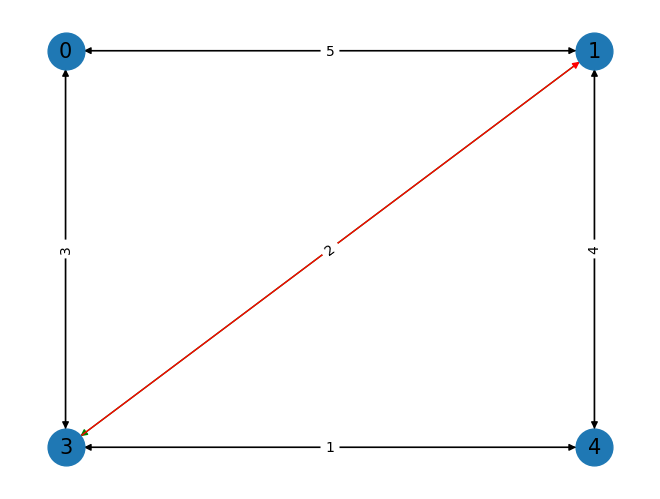

In [56]:
ans[0]
edge_colors = []
for u, v in G.edges():
    if qaoa_result.variables_dict[f'x_{u}_{v}'] == 1 and qaoa_result.variables_dict[f'x_{v}_{u}'] == 1:
        edge_colors.append('blue')
    elif qaoa_result.variables_dict[f'x_{u}_{v}'] == 1:
        edge_colors.append('red')
    elif qaoa_result.variables_dict[f'x_{v}_{u}'] == 1:
        edge_colors.append('green')
    else:
        edge_colors.append('black')
    # print(u, v, ans[0][f'x_{u}_{v}'])
pos = nx.get_node_attributes(G, 'pos')  # positions for all nodes
nx.draw(G, pos, with_labels=True, edge_color=edge_colors, node_size=700, font_size=15)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()